# PROBLEM SET 4: 
# NEURAL NETWORKS PART TWO

<br>
<br>
<br>

# PROBLEM 1 (40%)

In the lecture notebook we discussed how a neural network autoencoder trained with respect to the mean squared error objective function and no non-linearity can reproduce PCA. In this problem we want to show this explicitly. First, take the 0 and 1 digits from the sklearn digits dataset. 

In [5]:
from __future__ import print_function, division

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns; sns.set()

from sklearn.datasets import load_digits
digits = load_digits()
selector = digits.target<2
X = digits.data[selector]

Next, apply PCA to the dataset (ignoring the digit labels) and plot the resulting dimensional reduction down to $d=2$ (i.e. the projection onto the two leading principal components). Label each datapoint according to its digit label (e.g. red and blue). So far this is just reproducing what we've already done in the lecture notebook. But now we want to reproduce the same plot (or at least a very similar plot) using a neural network autoencoder. To do this you should do the following steps:

- use the FunctionApproximator class to train a neural network with the output vectors ($y_i$) equal to the correspoding input vectors ($x_i$), i.e. $y_i = x_i$ for all $i$ 


- use only two hidden units (this way we'll only get the two leading principal components) and set the activation function (i.e. the non-linearity) to none ('activation=None' as an argument to FunctionApproximator); note that the cost function is the mean squared error by default so we don't need to specify that explicitly


- use the get_y_pred() function in FunctionApproximator to get the vectors outputted by the neural network on the input vectors; note that although these predicted vectors are 64 dimensional they all in fact live in a 2-dimensional subspace, since they all had to pass through the 2 hidden units


- run PCA on these predicted output vectors and plot the transformed dataset by projecting onto the two leading principal components (basically this will just find the relevant two-dimensional subspace within the set of output vectors; the 'actual' PCA was done by the autoencoder it's just that we use the PCA class to easily identify the subspace that the autoencoder has chosen)


- plot the 'classical' PCA result next to the 'autoencoder' PCA result and comment briefly on the degree to which they are the same (make sure you've trained the neural network reasonably well; and note that the results may differ by a sign so you may want to transform the autoencoder result by a sign change to make things more directly comparable)

# solution

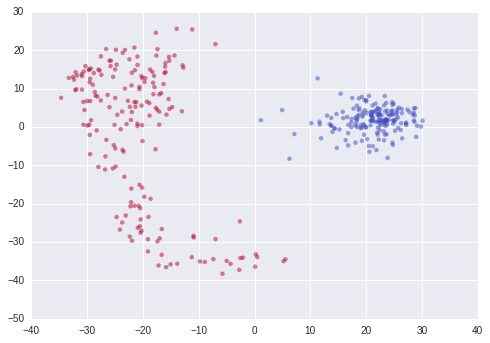

In [6]:
# Apply PCA to dataset and plot the resulting dimensional reduction down to d =2:
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 64 to 2 dimensions
Xproj = pca.fit_transform(X)
plt.scatter(Xproj[:, 0], Xproj[:, 1], c=digits.target[selector], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 10));

In [7]:
# Use NN to reproduce the same plot step by step:

#Step 1: set arguments as required. yi=xi, two hidden units, and 'activation=None'
from function_approximator import FunctionApproximator
fa = FunctionApproximator(n_in=64, n_out=64, n_hidden=2, activation=None)

#Step 2: train the model and use the get_y_pred() function to get outputted vectors:
fa.train(X, X, learning_rate=0.015, n_epochs=280000, report_frequency=20000)
Y_pred_auto = fa.get_y_pred()

epoch: 20000  cost: 9.150019
epoch: 40000  cost: 8.744043
epoch: 60000  cost: 8.276314
epoch: 80000  cost: 7.836409
epoch: 100000  cost: 7.490263
epoch: 120000  cost: 7.295768
epoch: 140000  cost: 7.216334
epoch: 160000  cost: 7.173867
epoch: 180000  cost: 7.152033
epoch: 200000  cost: 7.137078
epoch: 220000  cost: 7.125575
epoch: 240000  cost: 7.116361
epoch: 260000  cost: 7.108910
epoch: 280000  cost: 7.102876


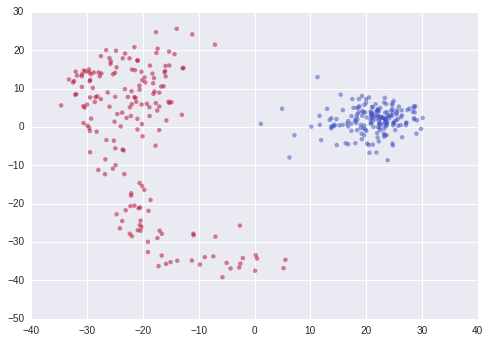

In [97]:
#Step 3:run PCA on these predicted output vectors and 
#plot the transformed dataset by projecting onto the two leading principal components
pca_auto = PCA(2)  
Xproj_auto = pca_auto.fit_transform(Y_pred_auto)
plt.scatter(Xproj_auto[:, 0], Xproj_auto[:, 1], c=digits.target[selector], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 10));

I see the two graph are very similar to each other


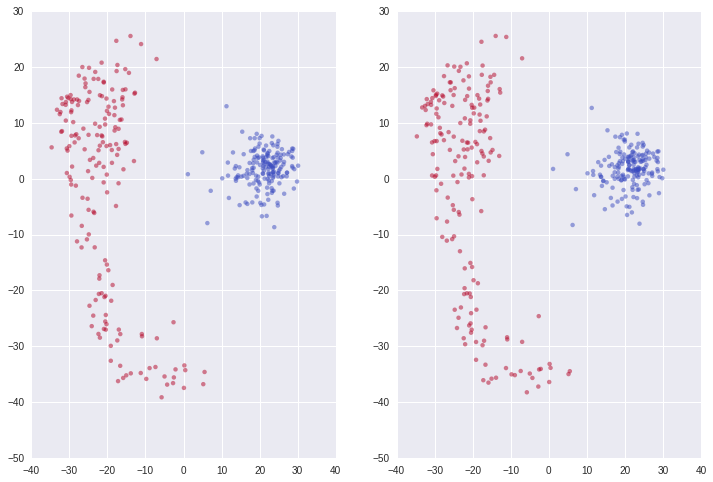

In [99]:
#Step 4:plot the 'classical' PCA result next to the 'autoencoder' PCA result 
#and comment briefly on the degree to which they are the same
fig, ((axA, axB)) = plt.subplots(nrows=1, ncols=2,figsize=(12,8))
axA.scatter(Xproj_auto[:, 0], Xproj_auto[:, 1], c=digits.target[selector], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 10));
axB.scatter(Xproj[:, 0], Xproj[:, 1], c=digits.target[selector], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('coolwarm', 10));

print("I see the two graph are very similar to each other")

<br><br><br>

# Problem 2 (40%)

In this problem we're going to use an RNN to do some time-series prediction. We're going to do the simplest possible thing, and so keep in mind that this a rather simplistic approach to time-series modeling (for example overfitting is a real concern). Nevertheless it allows us to play around with a concrete dataset in the RNN context.

First, download the Australian homicides data from

<a href=https://datamarket.com/data/set/238x/deaths-from-homicides-and-suicides-in-australia>$\texttt{https://datamarket.com/data/set/238x/deaths-from-homicides-and-suicides-in-australia}$</a>

That is, ignore the suicides and make sure to export the dataset in such a way that the deaths are broken down into deaths due to: (1) firearms and (2) non-firearms. This way you have two time-series, one for death rates of type (1) and one for death rates of type (2). In this excercise we're going to use the first time-series to predict the second.

__(a)__ Plot the input time-series (firearms) and the output time-series (non-firearms) and note that they have broadly similar trends/behavior

__(b)__ Plot the most naive guess you could for predicting the non-firearms time-series from the firearms time-series, i.e. plot an appropriately scaled version of the input time-series such that it approximately matches the output time-series (in particular choose the scale factor so that both predict the same _mean_ death rate over the time period 1915-2004). Overlay the true output in the same plot.

__(c)__ Train a RNN with 3 hidden units that uses the firearms time-series to predict the non-firearms time-series. Plot your resulting prediction and add it to the two curves plotted in part (b). Give a qualitative comparison to the 'naive' guess you made in part (b)

__(d)__ Suppose that the firearms death rate keeps dropping so that for the year 2005 the death rate per 100k people is 0.13 (Scenario 1). What does your model predict for the 2005 non-firearms death rate? What about if the firearms death rate in 2005 jumps to 0.25 (Scenario 2)? Note that the precise numerical answers here will depend somewhat on how long you trained your neural network, on the random initilization used during gradient descent, and so on.

__(e)__ In 1996 there was a notorious gun massacre in Australia. Since Australia evidently has a less sclerotic political culture/system than the United States, this led to gun reform laws, in particular a giant gun buy back program. This buy back program presumably was a large contributor to the drop in firearms homicides seen starting around that time. Retrain your RNN using only the years 1915-1995 (inclusive). Then using the actual values of the firearms death rate for 1915-2004 predict the non-firearms death rate over the entire period, in particular plotting the time period 1995-2004. Does excluding the years 1996-2004 from your training data modify your prediction for 1995-2004 substantially?

In [3]:
import pandas as pd
from rnn import RNN, MetaRNN
data=pd.read_csv('https://serv.cusp.nyu.edu/classes/ML_2016_Spring/session5/HW/homicides.csv')
input_seq=data['Firearm'][:-1]
output_seq=data['Non firearm'][:-1]

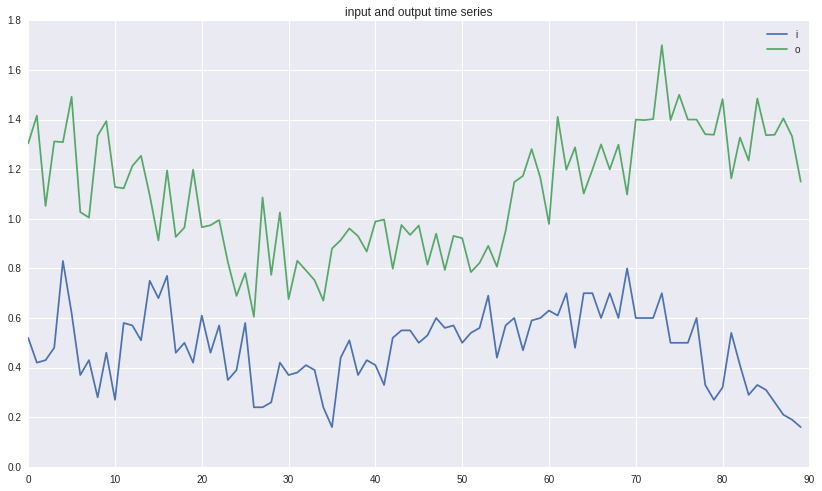

In [4]:
#(a)
fig = plt.figure(figsize=[14,8]);
plt.title("input and output time series")
plt.plot(input_seq)
plt.plot(output_seq)
plt.legend('i''o')
plt.show()

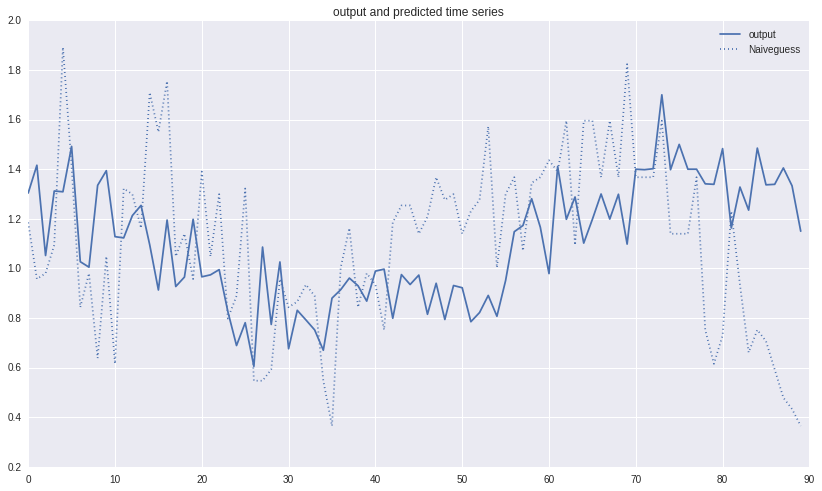

In [63]:
#(b) Naive Guess.
ratio = np.mean(output_seq)/np.mean(input_seq) #Get the average ratio between output and input
#Let's plot:
fig = plt.figure(figsize=[14,8]);
plt.title("output and predicted time series")
plt.plot(output_seq,label='output')
naive_guess = plt.plot(ratio*input_seq.reshape((90,1)), linestyle=':',label='Naiveguess');
#Plot predicted output by the ratio we get.
for i, x in enumerate(naive_guess):
    x.set_color(true_targets[i].get_color()); # This is just for changging colour.
plt.legend()
plt.show()

In [51]:
#(c)
# Train the model:
n_hidden = 3  # M
n_in = 1      # D
n_out = 1     # K

input_sequences  = np.array(input_seq).reshape((1, 90, 1))
output_sequences = np.array(output_seq).reshape((1, 90, 1))

model = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.07, learning_rate_decay=0.9996,
                    n_epochs=15000, activation='tanh')
model.fit(input_sequences, output_sequences, validation_frequency=1000)

... building the model
... training
epoch 1000, seq 1/1, train loss 0.056194 lr: 0.046937
epoch 2000, seq 1/1, train loss 0.058483 lr: 0.031461
epoch 3000, seq 1/1, train loss 0.055508 lr: 0.021087
epoch 4000, seq 1/1, train loss 0.054421 lr: 0.014134
epoch 5000, seq 1/1, train loss 0.033993 lr: 0.009473
epoch 6000, seq 1/1, train loss 0.055663 lr: 0.006350
epoch 7000, seq 1/1, train loss 0.055209 lr: 0.004256
epoch 8000, seq 1/1, train loss 0.054622 lr: 0.002853
epoch 9000, seq 1/1, train loss 0.053975 lr: 0.001912
epoch 10000, seq 1/1, train loss 0.053373 lr: 0.001282
epoch 11000, seq 1/1, train loss 0.052576 lr: 0.000859
epoch 12000, seq 1/1, train loss 0.050758 lr: 0.000576
epoch 13000, seq 1/1, train loss 0.029948 lr: 0.000386
epoch 14000, seq 1/1, train loss 0.023416 lr: 0.000259
epoch 15000, seq 1/1, train loss 0.023333 lr: 0.000173


rnn.py:336: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  self.y: train_set_y[index]})


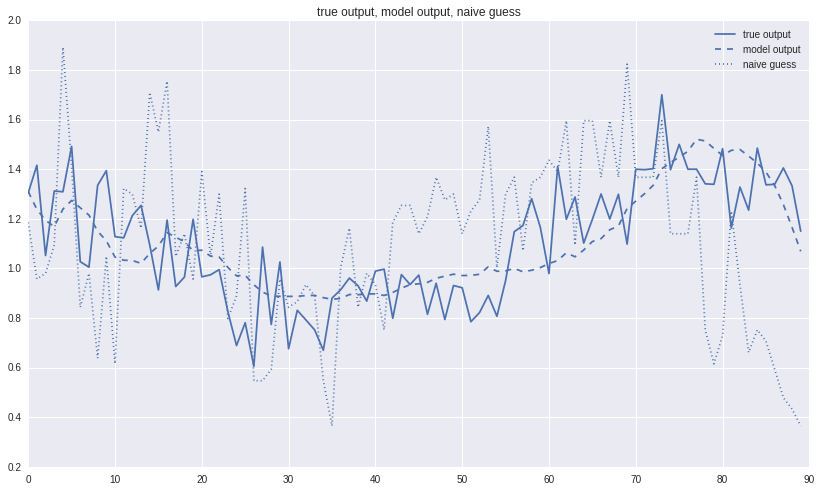

In [70]:
fig = plt.figure(figsize=[14,8]);

true_targets = plt.plot(output_seq,label='true output');

guess = model.predict(input_seq.reshape((90,1))) #Get the predicted output
guessed_targets = plt.plot(guess, linestyle='--',label='model output');
naive_guess = plt.plot(ratio*input_seq.reshape((90,1)), linestyle=':',label='naive guess');
for i, x in enumerate(guessed_targets):
    x.set_color(true_targets[i].get_color());
for i, x in enumerate(naive_guess):
    x.set_color(true_targets[i].get_color()); # This is just for changging colour.
plt.legend()
plt.title('true output, model output, naive guess'); # show rnn prediction for a single sequence


In [ ]:
# We see obviousely that our prediction by NN is much closer to the true output than naive guess, especially in 
#last twenty years.

In [77]:
#(d)
def predict_one_forward(new_value): # new_value is for 2015.
    input_seq_extend = input_seq.copy()
    input_seq_extend[90] = new_value
    guess = model.predict(input_seq_extend.reshape((91,1))) # input our new entire sequence (input) after adding 2015 value
    return guess[-1,0]

print("the non-firearms death rate in 2002-04 was:", np.array(output_seq)[-3:])
print("prediction for non-firearms death rate in 2005 in scenario 1: %.3f" % predict_one_forward(0.13))
print("prediction for non-firearms death rate in 2005 in scenario 2: %.3f" % predict_one_forward(0.25))

the non-firearms death rate in 2002-04 was: [ 1.405  1.333  1.15 ]
prediction for non-firearms death rate in 2005 in scenario 1: 0.986
prediction for non-firearms death rate in 2005 in scenario 2: 0.993


In [78]:
#(e)
#Make the new outputs and inputs since we only use data to 1995
input_seq_1995 = input_seq[0:81]
output_seq_1995 = output_seq[0:81]

# Train the model as in part(c)
n_hidden = 3  # M
n_in = 1      # D
n_out = 1     # K

input_sequences  = np.array(input_seq_1995).reshape((1, 81, 1))
output_sequences = np.array(output_seq_1995).reshape((1, 81, 1))

model2 = MetaRNN(n_in=n_in, n_hidden=n_hidden, n_out=n_out,
                    learning_rate=0.05, learning_rate_decay=0.9996,
                    n_epochs=15000, activation='tanh')
model2.fit(input_sequences, output_sequences, validation_frequency=1000)

... building the model
... training
epoch 1000, seq 1/1, train loss 0.050736 lr: 0.033527
epoch 2000, seq 1/1, train loss 0.047958 lr: 0.022472
epoch 3000, seq 1/1, train loss 0.021335 lr: 0.015062
epoch 4000, seq 1/1, train loss 0.021265 lr: 0.010096
epoch 5000, seq 1/1, train loss 0.021228 lr: 0.006767
epoch 6000, seq 1/1, train loss 0.021198 lr: 0.004536
epoch 7000, seq 1/1, train loss 0.021174 lr: 0.003040
epoch 8000, seq 1/1, train loss 0.021154 lr: 0.002038
epoch 9000, seq 1/1, train loss 0.021138 lr: 0.001366
epoch 10000, seq 1/1, train loss 0.021127 lr: 0.000915
epoch 11000, seq 1/1, train loss 0.021119 lr: 0.000614
epoch 12000, seq 1/1, train loss 0.021113 lr: 0.000411
epoch 13000, seq 1/1, train loss 0.021109 lr: 0.000276
epoch 14000, seq 1/1, train loss 0.021106 lr: 0.000185
epoch 15000, seq 1/1, train loss 0.021104 lr: 0.000124


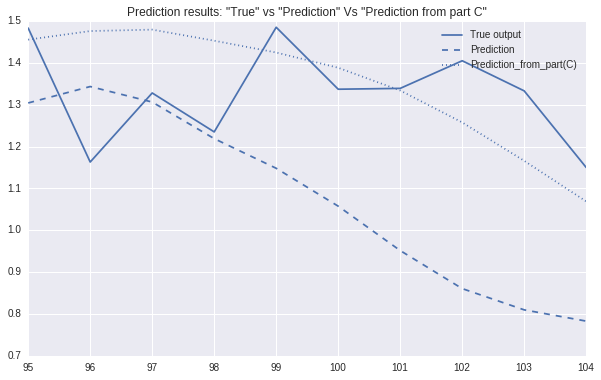

Excluding data after 1995 does effect the prediction quality and we see it underestimates the true output


In [93]:
# Do the prediction for the 
fig = plt.figure(figsize=[10,6]);
years = np.arange(95,105)
true_targets = plt.plot(years,output_seq[-10:].values,label='True output'); # True values
guess = model2.predict(input_seq.reshape((90,1))) #Input the entire sequences into our model trained by data before 1995.
guessed_targets = plt.plot(years,guess[-10:], linestyle='--',label='Prediction');#prediction

guess_before = model.predict(input_seq.reshape((90,1))) #Get the predicted output
guessed_targets_before = plt.plot(years,guess_before[-10:], linestyle=':',label='Prediction_from_part(C)');

for i, x in enumerate(guessed_targets):
    x.set_color(true_targets[i].get_color()); # This is just for changging colour.
for i, x in enumerate(guessed_targets_before):
    x.set_color(true_targets[i].get_color()); 

plt.title('Prediction results: "True" vs "Prediction" Vs "Prediction from part C"')
plt.legend()
plt.show()

print("Excluding data after 1995 does effect the prediction quality and we see it underestimates the true output")

### Excluding the years 1996 and onward makes the predicted reduction in non-firearms deaths substantially larger.

<br><br>
# Problem 3 (20%)

__(a)__ How many parameters (i.e. in the weight matrices and bias vectors, not hyperparameters) does the neural network in problem 1 have?

__(b)__ How many parameters (i.e. in the weight matrices and bias vectors, not hyperparameters) does the recurrent neural network in problem 2 have?

# solution

__(a)__ Let's count up the parameters one-by-one:

- $\bf W^{(1)}$ has  $n_{\rm input} \times n_{\rm hidden}$ parameters (so 128)
- $\bf b^{(1)}$ has  $n_{\rm hidden}$ parameters (so 2)
- $\bf W^{(2)}$ has  $n_{\rm output} \times n_{\rm hidden}$ parameters (so 128)
- $\bf b^{(2)}$ has  $n_{\rm output}$ parameters (so 64)

We have 2 hidden units ${d_1,d_2}$, and 64 inputs $(x_1,x_2,...,x_{64})$.

$d_1=a_1^1*x_1+a_2^1*x_2+...+a_{64}^1*x_{64}+b_1$  

$d_2=a_1^2*x_1+a_2^2*x_2+...+a_{64}^2*x_{64}+b_2$

$W^{(1)}=\begin{pmatrix}
    a_{1}^1       & a_{2}^1 & a_{3}^1 & \dots & a_{64}^1 \\
    a_{1}^2       & a_{2}^2 & a_{3}^2 & \dots & a_{64}^2 \\
\end{pmatrix}$ 

and $b^{(1)}=(b_1,b_2)$

Total: 64x2=128 for $W^{(1)}$ and 2 for $b^{(1)}$

Similarly, we have 64 outputs, $y_1$... $y_{64}$, let $g()$ be the "activation" function.

$y_1=c_1^1*g(d_1)+c_2^1*g(d_2)+e_1$

$y_2=c_1^2*g(d_1)+c_2^2*g(d_2)+e_2$

...

$y_{64}=c_1^{64}*g(d_1)+c_2^{64}*g(d_2)+e_{64}$


$W^{(2)}=\begin{pmatrix}
    c_{1}^1 & c_{2}^1\\
    c_{1}^2 & c_{2}^2\\
    c_{1}^3 & c_{2}^3\\
    . . . & ...\\
    c_{1}^{64} & c_{2}^{64}\\
\end{pmatrix}$

and $b^{(2)}=(e_1,e_2,...e_{64})$
So,total: 2x64=128 for $W^{(2)}$ and 1x64 =64 for $b^{(2)}$.

This yields a total of $128+2+128+64= 322$ parameters



__(b)__ Let's count up the parameters one-by-one:

We have same parameters for every time period. So we only need to consider for one period from $t$ to $t+1$ for example.

We have one input for time period t+1: $x^{t+1}$, three hidden units for time t+1: $z_1^{t+1},z_2^{t+1},z_3^{t+1}$.

- $\bf W^{({\rm i}\to{\rm h})}$ has $1 \times 3 = 3$ parameters : $w_1$,$w_2$,$w_3$

- $\bf W^{({\rm h}\to{\rm h})}$ has $3 \times 3 = 9$ parameters:
$r_1,r_2,r_3,...r_9$

- $\bf b^{({\rm h})}$ (the bias vector on the activation) has $3$ parameters: $b_1,b_2,b_3$


$z_1^{t+1}=r_1z_1^t+r_2z_2^t+r_3z_3^t+ w_1x^{t+1}+b_1$

$z_2^{t+1}=r_4z_1^t+r_5z_2^t+r_6z_3^t +w_2x^{t+1}+b_2$

$z_3^{t+1}=r_7z_1^t+r_8z_2^t+r_9z_3^t +w_3x^{t+1}+b_3$


We have one output: $y$ and three hidden units:$z_1^{t+1},z_2^{t+1},z_3^{t+1}$. (Also assume the "activation" function is: $g()$). So

- $\bf W^{({\rm h}\to{\rm o})}$ has $1 \times 3 = 3$ parameters: $v_1, v_2,v_3$
- $\bf b^{({\rm o})}$ (the bias vector on the output) has $1$ parameter:$b_4$

$y=v_1g(z_1^{t+1})+v_2g(z_2^{t+1})+v_3g(z_3^{t+1})+b_4$

This yields a total of $19$ parameters


